# 04 - H2O AutoML 企业级应用

> 🎯 学习目标：掌握H2O AutoML的企业级特性，理解分布式训练和模型可解释性

---

## 📚 本节内容

1. H2O AutoML 简介
2. 基础使用
3. 排行榜分析
4. 模型可解释性
5. 分布式训练
6. 模型部署

---

## 🏢 H2O AutoML 企业级特性

### 核心优势

1. **企业级功能** 🏭
   - 分布式训练
   - 生产级部署
   - 模型监控

2. **可解释性强** 🔍
   - SHAP值分析
   - 变量重要性
   - 部分依赖图

3. **Web界面** 🌐
   - Flow UI可视化
   - 无代码操作

4. **模型导出** 📦
   - MOJO/POJO格式
   - 跨平台部署

---

## 1. 安装与初始化

In [3]:
# ==================== 1. 安装与初始化 H2O ====================
#
# 📦 H2O 依赖说明:
#
# H2O 是一个开源的分布式机器学习平台
# 主要依赖:
# - h2o: 核心库,包含 AutoML、分布式训练、模型部署等功能
# - Java 8+: H2O 底层基于 Java 实现,必须安装 Java 运行环境
# - pandas/numpy: 数据处理库 (可选,用于与 Python 生态集成)
#
# 💡 安装命令:
# pip install h2o
#
# ⚠️ 重要提示:
# - H2O 需要 Java 8 或更高版本
# - 检查 Java 版本: java -version
# - 如未安装 Java,请先安装: https://www.oracle.com/java/technologies/downloads/
#
# 📚 H2O 的核心特性:
#
# 1. **分布式架构**:
#    - 可在单机或集群上运行
#    - 内存高效,支持 TB 级数据
#    - 自动并行化计算
#
# 2. **AutoML 功能**:
#    - 自动模型选择和超参数优化
#    - Stacking 集成策略
#    - 排行榜机制
#
# 3. **企业级部署**:
#    - MOJO/POJO 模型导出
#    - 跨平台推理 (Java/Python/R/Scala)
#    - 高性能、低延迟
#
# 4. **可解释性**:
#    - 变量重要性
#    - 部分依赖图 (PDP)
#    - SHAP 值支持
#
# 5. **Web UI**:
#    - Flow 界面,无代码操作
#    - 实时监控训练过程
#    - 交互式可视化

# 安装 H2O
# !pip install h2o
# 注意：需要 Java 8+ 环境

import h2o
from h2o.automl import H2OAutoML
import pandas as pd
import numpy as np

# ==================== 初始化 H2O 集群 ====================
#
# 📚 h2o.init() 函数详解:
#
# 这是使用 H2O 的第一步,会启动一个本地 H2O 集群
#
# 💡 关键参数详解:
#
# **max_mem_size='4G'**:
#   - 分配给 H2O 的最大内存
#   - 格式: '4G', '8G', '16G' 等
#   - 建议设置:
#     * 小数据集 (< 1GB): 2-4G
#     * 中等数据集 (1-10GB): 8-16G
#     * 大数据集 (> 10GB): 32G+ 或使用集群
#   - 注意: 不要超过系统可用内存的 80%
#
# **nthreads=-1**:
#   - 使用的 CPU 线程数
#   - -1: 使用所有可用核心 (推荐)
#   - 1-N: 指定线程数
#   - 影响: 线程越多,并行训练越快
#
# 🔍 初始化过程:
# 1. 检查 Java 环境
# 2. 启动本地 H2O 服务器
# 3. 分配内存和线程资源
# 4. 初始化集群通信
#
# ⏱️ 初始化时间:
# - 通常需要 5-15 秒
# - 首次启动可能较慢
#
# 💡 企业级场景:
# - 可以连接到远程 H2O 集群
# - 支持多节点分布式训练
# - 使用 h2o.connect() 连接现有集群

# 初始化 H2O
h2o.init(
    max_mem_size='4G',    # 最大内存: 4GB
    nthreads=-1           # 使用所有CPU核心
)

print("=" * 70)
print("✅ H2O 初始化成功")
print("=" * 70)
print("\n📊 集群状态:")
print(h2o.cluster().show_status())

print("\n💡 H2O 集群信息:")
print(f"  - H2O 版本: {h2o.__version__}")
print(f"  - 集群节点数: {h2o.cluster().cloud_size}")
print(f"  - 可用内存: {h2o.cluster().free_mem}")
print(f"  - CPU 核心数: {h2o.cluster().num_cpus}")
print("=" * 70)

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,18 mins 25 secs
H2O_cluster_timezone:,Asia/Shanghai
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.9
H2O_cluster_version_age:,8 days
H2O_cluster_name:,H2O_from_python_lyh_tmn3ml
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.889 Gb
H2O_cluster_total_cores:,10
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


✅ H2O 初始化成功

📊 集群状态:


H2O_cluster_uptime:,18 mins 25 secs
H2O_cluster_timezone:,Asia/Shanghai
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.9
H2O_cluster_version_age:,8 days
H2O_cluster_name:,H2O_from_python_lyh_tmn3ml
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.889 Gb
H2O_cluster_total_cores:,10
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


None

💡 H2O 集群信息:
  - H2O 版本: 3.46.0.9
  - 集群节点数: 1


AttributeError: Unknown attribute `free_mem` on object of type `H2OCluster`, this property is not available for this H2O backend [version=3.46.0.9].

---

## 🧠 H2O AutoML 核心原理深度讲解

> 💡 **为什么要学习 H2O 的核心原理？**
>
> 理解 H2O AutoML 的底层机制是掌握这个工具的关键！
> 它解释了：
> - 为什么 H2O 能处理大数据集？→ 分布式架构
> - 为什么 H2O 的模型性能通常很好？→ Stacking 集成
> - 如何从排行榜中学习？→ 理解模型选择逻辑

---

### 1. H2O 的分布式架构 ⭐

#### 1.1 什么是分布式架构？

**传统单机 AutoML (如 PyCaret, Auto-sklearn)**:
```
Python 进程
  └── 所有数据和计算都在单个进程内
  └── 受限于单机内存和CPU
  └── 无法处理超大数据集
```

**H2O 分布式架构**:
```
Python 客户端 ←→ H2O 集群
                 ├── 节点1 (数据分片1)
                 ├── 节点2 (数据分片2)
                 └── 节点3 (数据分片3)
```

#### 1.2 H2O 集群的工作原理

**数据分片 (Data Sharding)**:
- 大数据集被切分成多个小块
- 每个小块存储在不同节点
- 并行处理,避免单节点内存瓶颈

**并行计算**:
- 模型训练在所有节点并行执行
- 每个节点处理自己的数据分片
- 最后聚合结果

**内存高效**:
- 数据以列式存储 (Column-based)
- 压缩存储,节省内存
- 支持处理大于内存的数据 (Out-of-core)

#### 1.3 单机 vs 集群模式

| 特性 | 单机模式 | 集群模式 |
|------|---------|---------|
| **节点数** | 1 | 多个 (2-数百) |
| **数据规模** | GB 级 | TB-PB 级 |
| **训练速度** | 中等 | 快 (并行加速) |
| **适用场景** | 开发、小数据 | 生产、大数据 |
| **配置难度** | 简单 | 需要集群管理 |

**本教程使用单机模式**:
- h2o.init() 启动单节点集群
- 适合学习和小数据集
- 企业级应用可扩展到多节点

#### 1.4 H2O vs 其他 AutoML 的架构对比

| 工具 | 架构 | 内存管理 | 大数据支持 |
|------|------|---------|-----------|
| **H2O** | 分布式 | 列式存储,压缩 | ✅ 优秀 |
| **PyCaret** | 单机 (基于 sklearn) | Pandas DataFrame | ⚠️ 受限 |
| **FLAML** | 单机 | NumPy/Pandas | ⚠️ 受限 |
| **Auto-sklearn** | 单机 | NumPy | ⚠️ 受限 |

---

### 2. Stacking 集成策略详解 ⭐⭐

> 💡 **这是 H2O AutoML 的核心竞争力！**

#### 2.1 什么是 Stacking (堆叠集成)？

**直观理解**:
想象你在做一个重要决定,你会:
1. 咨询多个专家 (基础模型)
2. 每个专家给出自己的意见
3. 一个"超级专家" (元学习器) 综合所有意见
4. 给出最终决策

这就是 Stacking 的思想！

**数学定义**:
```
基础模型: M1, M2, M3, ..., Mn
元学习器: Meta

训练过程:
1. 在训练集上训练 M1, M2, ..., Mn
2. 用 M1, M2, ..., Mn 对验证集进行预测 → P1, P2, ..., Pn
3. 将 [P1, P2, ..., Pn] 作为新特征
4. 训练元学习器 Meta: Meta([P1, P2, ..., Pn]) → 最终预测

预测过程:
1. 用 M1, M2, ..., Mn 对测试样本预测 → P1', P2', ..., Pn'
2. 元学习器: Meta([P1', P2', ..., Pn']) → 最终结果
```

#### 2.2 H2O 的两层 Stacking 架构

**第一层: Base Learners (基础学习器)**

H2O 会训练多种算法:
- GBM (Gradient Boosting Machine) - 多个不同配置
- XGBoost - 多个不同配置
- Random Forest (DRF)
- GLM (Generalized Linear Model)
- Deep Learning (神经网络)

每种算法会尝试不同的超参数配置,例如:
- GBM_1: 100棵树, 深度5
- GBM_2: 200棵树, 深度10
- XGBoost_1: learning_rate=0.1
- XGBoost_2: learning_rate=0.01

**第二层: Meta Learner (元学习器)**

将所有基础模型的预测作为输入:
```
Meta Learner 的输入:
- GBM_1 的预测
- GBM_2 的预测
- XGBoost_1 的预测
- ...

Meta Learner 学习:
- 哪个模型更可信？
- 哪些模型组合效果最好？
- 如何权衡不同模型的意见？
```

常用的元学习器:
- GLM (默认): 快速,可解释
- GBM: 性能更好,但更复杂
- Deep Learning: 适合复杂模式

#### 2.3 Stacking 为什么有效？

**偏差-方差分解**:
- 单模型: 可能高偏差 (欠拟合) 或高方差 (过拟合)
- Stacking: 结合多个模型,减少偏差和方差

**多样性**:
- 不同算法有不同的归纳偏置
- 例如: GLM 擅长线性关系, GBM 擅长非线性
- 组合后可以覆盖更广的模式空间

**错误互补**:
- 不同模型在不同样本上可能犯错
- 但不太可能所有模型都在同一样本上犯错
- 元学习器可以识别并纠正单模型的错误

#### 2.4 H2O 的 Stacking 类型

**StackedEnsemble_AllModels**:
- 使用所有训练过的基础模型
- 模型数量最多 (10-20个)
- 通常性能最好
- 推理速度最慢

**StackedEnsemble_BestOfFamily**:
- 每种算法只选最好的一个
- 例如: 最好的 GBM + 最好的 XGBoost + ...
- 模型数量适中 (5-8个)
- 平衡性能和速度

#### 2.5 Stacking 的代价

**优点**:
- ✅ 性能提升 5-15%
- ✅ 鲁棒性强
- ✅ 减少过拟合风险

**缺点**:
- ❌ 模型复杂度高
- ❌ 推理速度慢 (需要所有基础模型预测)
- ❌ 可解释性差
- ❌ 占用更多内存

**何时使用 Stacking？**
- 竞赛: ✅ (追求极致性能)
- 生产环境: ⚠️ (需权衡性能和延迟)
- 可解释性要求高: ❌ (选择单模型)

---

### 3. 排行榜机制深度解读 ⭐

#### 3.1 排行榜的生成过程

**步骤1: 模型训练**
- H2O 并行训练多个模型
- 每个模型使用交叉验证评估

**步骤2: 性能计算**
```
对于每个模型:
1. 5折交叉验证
2. 计算每折的性能指标
3. 取平均值作为模型得分
```

**步骤3: 排序**
- 根据 sort_metric 排序
- 性能最好的模型排在最前

**步骤4: 实时更新**
- 训练过程中排行榜持续更新
- 可以随时查看当前最佳模型

#### 3.2 交叉验证策略

**为什么使用交叉验证？**
- 避免单次划分的随机性
- 更准确地评估泛化性能
- 检测过拟合

**H2O 的交叉验证过程**:
```
原始训练集 (100%)
  ↓
5 折划分:
  Fold 1: 训练 (80%) + 验证 (20%)
  Fold 2: 训练 (80%) + 验证 (20%)
  Fold 3: 训练 (80%) + 验证 (20%)
  Fold 4: 训练 (80%) + 验证 (20%)
  Fold 5: 训练 (80%) + 验证 (20%)
  ↓
平均性能 → 排行榜得分
```

#### 3.3 模型多样性保证

H2O 如何确保训练的模型具有多样性？

**算法多样性**:
- 尝试多种算法家族 (树、线性、神经网络)
- 不同算法有不同的归纳偏置

**超参数多样性**:
- 随机网格搜索
- 不同的树深度、学习率、正则化参数
- 确保不会所有模型都相似

**数据采样多样性**:
- Bagging (Bootstrap Aggregating)
- 每个模型看到的数据略有不同

#### 3.4 从排行榜中学习

**看榜首模型类型**:
- 如果 Stacking 榜首 → 数据复杂,需要组合多模型
- 如果单模型 (如 GBM) 榜首 → 数据相对简单

**看算法排名**:
- GLM 排前 → 数据可能有线性关系
- 树模型排前 → 数据有复杂非线性关系
- Deep Learning 排前 → 数据有深层特征交互

**看性能差距**:
- 榜首和第二名差距大 → Stacking 优势明显
- 榜首和第二名接近 → 单模型也足够好

---

### 4. H2O vs 其他 AutoML 工具核心对比 📊

| 特性 | H2O AutoML | FLAML | PyCaret | Auto-sklearn |
|------|-----------|-------|---------|--------------|
| **核心算法** | Stacking | CFO (成本优化) | 遍历对比 | 贝叶斯优化 + Meta-learning |
| **分布式** | ✅ 支持 | ❌ 单机 | ❌ 单机 | ❌ 单机 |
| **大数据** | ✅ TB 级 | ⚠️ GB 级 | ⚠️ GB 级 | ⚠️ GB 级 |
| **模型融合** | ✅ 自动 Stacking | ❌ 无 | ✅ 手动融合 | ✅ 自动 Ensemble |
| **排行榜** | ✅ 实时 | ❌ 无 | ✅ 有 | ✅ 有 |
| **企业级** | ✅ MOJO 部署 | ⚠️ 基础 | ⚠️ 基础 | ⚠️ 基础 |
| **速度** | ⭐⭐⭐⭐ | ⭐⭐⭐⭐⭐ | ⭐⭐⭐⭐ | ⭐⭐⭐ |
| **易用性** | ⭐⭐⭐ | ⭐⭐⭐⭐ | ⭐⭐⭐⭐⭐ | ⭐⭐⭐ |

**H2O 的独特优势**:
1. **分布式架构** - 唯一支持大数据的 AutoML
2. **Stacking 集成** - 自动化的模型融合
3. **企业级部署** - MOJO 跨平台推理
4. **可解释性** - SHAP、PDP、变量重要性

**何时选择 H2O？**
- ✅ 数据量大 (> 10GB)
- ✅ 需要极致性能 (Stacking)
- ✅ 企业级生产环境
- ✅ 需要强大的可解释性工具
- ❌ 追求最快速度 (选 FLAML)
- ❌ 需要最简单的 API (选 PyCaret)

---

💡 **接下来**: 我们将在实际案例中观察这些原理的应用！

---

## 2. 分类任务基础使用

### 2.1 加载数据

In [4]:
# ==================== 2.1 加载数据 ====================
#
# 📚 H2O 数据加载方式:
#
# H2O 使用自己的数据结构 H2OFrame (类似 Pandas DataFrame)
# 主要加载方式:
# 1. **从 URL 加载**: h2o.import_file(url) - 最常用
# 2. **从本地文件**: h2o.import_file('path/to/file.csv')
# 3. **从 Pandas**: h2o.H2OFrame(pandas_df)
# 4. **从 NumPy**: h2o.H2OFrame(numpy_array)
#
# 💡 H2OFrame vs Pandas DataFrame:
#
# **相同点**:
# - 都是表格数据结构
# - 都支持列名、索引、切片
# - API 相似 (head, tail, describe 等)
#
# **不同点**:
# - H2OFrame 存储在 H2O 集群内存中 (分布式)
# - Pandas DataFrame 存储在 Python 进程内存中 (单机)
# - H2OFrame 可处理大于内存的数据
# - H2OFrame 支持并行计算和分布式处理
#
# 🎯 为什么使用 H2OFrame?
# - 与 H2O 算法无缝集成
# - 自动内存管理和优化
# - 支持大数据集
# - 分布式计算加速
#
# 📊 本示例数据集: Iris (鸢尾花)
#
# - 来源: UCI Machine Learning Repository
# - 样本数: 150
# - 特征数: 4 (花萼长度、花萼宽度、花瓣长度、花瓣宽度)
# - 类别数: 3 (Setosa、Versicolor、Virginica)
# - 任务类型: 多分类
# - 数据特点: 小型、平衡、无缺失值
#
# 💡 为什么选择 Iris 数据集?
# 1. 经典基准数据集,便于理解
# 2. 数据量小,训练速度快,适合演示
# 3. 特征少,便于可视化和解释
# 4. 类别平衡,适合多分类任务

# 从URL加载数据
data_url = "https://s3.amazonaws.com/h2o-public-test-data/smalldata/iris/iris_wheader.csv"

print("=" * 70)
print("🔄 正在从 URL 加载数据...")
print(f"数据源: {data_url}")
print("=" * 70)

data = h2o.import_file(data_url)

# 查看数据基本信息
print("\n📊 数据形状:")
print(f"  - 行数 (样本): {data.shape[0]}")
print(f"  - 列数 (特征): {data.shape[1]}")

print("\n📋 列名:")
print(f"  {data.columns}")

print("\n🔍 数据类型:")
print(data.types)

print("\n" + "=" * 70)
print("前5行数据:")
print("=" * 70)
data.head()

🔄 正在从 URL 加载数据...
数据源: https://s3.amazonaws.com/h2o-public-test-data/smalldata/iris/iris_wheader.csv
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%

📊 数据形状:
  - 行数 (样本): 150
  - 列数 (特征): 5

📋 列名:
  ['sepal_len', 'sepal_wid', 'petal_len', 'petal_wid', 'class']

🔍 数据类型:
{'sepal_len': 'real', 'sepal_wid': 'real', 'petal_len': 'real', 'petal_wid': 'real', 'class': 'enum'}

前5行数据:


sepal_len,sepal_wid,petal_len,petal_wid,class
5.1,3.5,1.4,0.2,Iris-setosa
4.9,3,1.4,0.2,Iris-setosa
4.7,3.2,1.3,0.2,Iris-setosa
4.6,3.1,1.5,0.2,Iris-setosa
5,3.6,1.4,0.2,Iris-setosa
5.4,3.9,1.7,0.4,Iris-setosa
4.6,3.4,1.4,0.3,Iris-setosa
5,3.4,1.5,0.2,Iris-setosa
4.4,2.9,1.4,0.2,Iris-setosa
4.9,3.1,1.5,0.1,Iris-setosa


### 2.2 数据准备

In [5]:
# ==================== 2.2 数据准备 ====================
#
# 📚 H2O 数据准备步骤:
#
# 1. **设置目标变量和特征**
# 2. **类型转换** (分类任务需要将目标变量转为因子)
# 3. **数据划分** (训练集和测试集)
#
# 💡 关键概念详解:
#
# **目标变量 (target)**:
# - 我们要预测的列
# - 分类任务: 类别标签 (如 'class', 'label')
# - 回归任务: 连续数值 (如 'price', 'sales')
#
# **特征 (features)**:
# - 用于预测的输入变量
# - 通常是除目标变量外的所有列
# - 可以手动选择重要特征
#
# 🎯 asfactor() 详解:
#
# **什么是 asfactor()?**
# - 将列转换为分类类型 (因子/枚举)
# - 类似 Pandas 的 astype('category')
#
# **为什么需要 asfactor()?**
# - H2O 需要明确区分分类任务和回归任务
# - 分类算法只接受因子类型的目标变量
# - 如果不转换,H2O 会将其视为回归任务
#
# **何时使用?**
# - 分类任务: 必须对目标变量使用 asfactor()
# - 回归任务: 不需要 (保持数值类型)
# - 分类特征: 可选 (某些算法会自动处理)
#
# 🔍 split_frame() 详解:
#
# **功能**:
# - 将数据随机划分为训练集和测试集
# - H2O 自己的数据划分方法
#
# **参数说明**:
# - ratios=[0.8]: 训练集占 80%, 测试集占 20%
# - ratios=[0.7, 0.15]: 训练集 70%, 验证集 15%, 测试集 15%
# - seed=42: 随机种子,保证结果可复现
#
# **与 sklearn 的区别**:
# - sklearn: train_test_split(X, y, test_size=0.2)
# - H2O: data.split_frame(ratios=[0.8])
#
# **优势**:
# - 直接在 H2O 集群中操作,无需数据传输
# - 支持多路划分 (train/valid/test)
# - 分布式处理,速度快

# 设置目标变量和特征
target = 'class'  # 目标列: 鸢尾花的类别
features = data.columns  # 所有列
features.remove(target)  # 移除目标列,剩下的就是特征

print("=" * 70)
print("🎯 数据准备")
print("=" * 70)
print(f"\n目标变量: {target}")
print(f"特征列表: {features}")
print(f"特征数量: {len(features)}")

# 将目标变量转换为因子（分类）
# 这是分类任务的关键步骤！
print("\n🔄 转换目标变量为因子类型...")
print(f"  转换前类型: {data[target].type}")

data[target] = data[target].asfactor()

print(f"  转换后类型: {data[target].type}")
print(f"  类别数量: {data[target].nlevels()[0]}")
print(f"  类别标签: {data[target].levels()[0]}")

# 划分训练集和测试集
# ratios=[0.8] 表示 80% 训练, 20% 测试
print("\n📊 划分训练集和测试集...")
print("  划分比例: 80% 训练集, 20% 测试集")
print("  随机种子: 42 (保证可复现)")

train, test = data.split_frame(ratios=[0.8], seed=42)

print(f"\n✅ 数据划分完成:")
print(f"  训练集: {train.shape[0]} 行 × {train.shape[1]} 列")
print(f"  测试集: {test.shape[0]} 行 × {test.shape[1]} 列")
print(f"  训练集占比: {train.shape[0] / data.shape[0]:.1%}")
print("=" * 70)

🎯 数据准备

目标变量: class
特征列表: ['sepal_len', 'sepal_wid', 'petal_len', 'petal_wid']
特征数量: 4

🔄 转换目标变量为因子类型...
  转换前类型: <bound method H2OFrame.type of H2OFrame({'_ex': <Expr(cols_py <Expr()#iris_wheader1.hex> 'class'); scalar>})>
  转换后类型: <bound method H2OFrame.type of H2OFrame({'_ex': <Expr(cols_py <Expr(:= <Expr()#iris_wheader1.hex> <Expr(as.factor <Expr(cols_py <Expr()#iris_wheader1.hex> 'class'); scalar>); scalar> 4 None); scalar> 'class'); scalar>})>
  类别数量: 3
  类别标签: ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']

📊 划分训练集和测试集...
  划分比例: 80% 训练集, 20% 测试集
  随机种子: 42 (保证可复现)

✅ 数据划分完成:
  训练集: 121 行 × 5 列
  测试集: 29 行 × 5 列
  训练集占比: 80.7%


### 2.3 训练 H2O AutoML

In [6]:
# ==================== 2.3 训练 H2O AutoML ====================
#
# 📚 H2OAutoML 类详解:
#
# H2OAutoML 是 H2O 的自动机器学习接口
# 会自动完成:
# 1. **模型选择**: 尝试多种算法 (GBM、XGBoost、GLM、DRF 等)
# 2. **超参数优化**: 为每个模型搜索最优参数
# 3. **模型融合**: 使用 Stacking 集成多个模型
# 4. **排行榜**: 根据性能排序所有模型
# 5. **早停**: 如果性能不再提升,自动停止
#
# 💡 关键参数详解:
#
# **max_runtime_secs=300**:
#   - 最大运行时间 (秒)
#   - H2O 会在此时间内尽可能多地训练模型
#   - 建议设置:
#     * 快速验证: 60-180秒 (1-3分钟)
#     * 标准训练: 300-1800秒 (5-30分钟)
#     * 深度搜索: 3600-7200秒 (1-2小时)
#   - 注意: 这是"上限",可能提前结束
#
# **max_models=20**:
#   - 最多训练的模型数量
#   - 包括: 单模型 + Stacking 模型
#   - 实际数量可能少于此值 (受时间限制)
#   - 建议: 10-50 (太少效果差,太多浪费时间)
#
# **seed=42**:
#   - 随机种子,保证结果可复现
#   - 影响: 数据采样、超参数初始化
#
# **nfolds=5**:
#   - 交叉验证折数
#   - 用途: 评估模型性能,避免过拟合
#   - 工作原理:
#     1. 将训练集分为 5 份
#     2. 每次用 4 份训练, 1 份验证
#     3. 重复 5 次,取平均性能
#   - 建议: 5 或 10 (折数越多越准确但越慢)
#
# **sort_metric='AUTO'**:
#   - 排行榜排序指标
#   - 'AUTO': 自动选择 (分类用 AUC, 回归用 RMSE)
#   - 分类可选: 'AUC', 'logloss', 'mean_per_class_error'
#   - 回归可选: 'RMSE', 'MSE', 'MAE', 'RMSLE'
#
# 🔍 H2O AutoML 的训练流程:
#
# 1. **基础模型训练** (Base Learners):
#    - GBM (Gradient Boosting Machine)
#    - XGBoost
#    - Random Forest (DRF)
#    - GLM (Generalized Linear Model)
#    - Deep Learning (神经网络)
#    - Naive Bayes (仅分类)
#
# 2. **超参数优化**:
#    - 随机网格搜索
#    - 贝叶斯优化
#    - 早停策略
#
# 3. **Stacking 集成**:
#    - 将多个基础模型组合
#    - 训练元学习器 (Meta Learner)
#    - 通常是排行榜榜首
#
# 4. **排行榜更新**:
#    - 实时更新模型性能
#    - 根据 sort_metric 排序
#
# ⏱️ 训练时间说明:
#
# - 受 max_runtime_secs 和 max_models 双重限制
# - 时间到或模型数到达上限,训练结束
# - 实际耗时通常略超过设定值 (完成当前模型训练)
#
# 💡 企业级最佳实践:
#
# - 开发阶段: max_runtime_secs=300, 快速验证
# - 生产阶段: max_runtime_secs=3600+, 追求性能
# - 大数据集: 增加 max_mem_size, 使用集群
# - 类别不平衡: 设置 balance_classes=True

# 创建 AutoML 对象
aml = H2OAutoML(
    max_runtime_secs=300,      # 最大运行时间: 5分钟
    max_models=20,             # 最多训练20个模型
    seed=42,                   # 随机种子
    nfolds=5,                  # 5折交叉验证
    sort_metric='AUTO'         # 自动选择排序指标
)

# 训练
print("=" * 70)
print("🚀 开始 H2O AutoML 训练")
print("=" * 70)
print(f"\n⚙️ 训练配置:")
print(f"  - 任务类型: 分类 (Classification)")
print(f"  - 最大运行时间: 300 秒 (5 分钟)")
print(f"  - 最多模型数: 20")
print(f"  - 交叉验证: 5 折")
print(f"  - 训练集大小: {train.shape[0]} 样本")
print(f"  - 特征数: {len(features)}")
print(f"  - 类别数: {train[target].nlevels()[0]}")

print(f"\n📊 H2O 将自动尝试以下算法:")
print("  1. GBM (Gradient Boosting Machine)")
print("  2. XGBoost")
print("  3. Random Forest (DRF)")
print("  4. GLM (Generalized Linear Model)")
print("  5. Deep Learning (神经网络)")
print("  6. Stacking Ensemble (模型融合)")

print(f"\n⏳ 正在训练,请耐心等待...")
print("=" * 70)
print()

import time
start_time = time.time()

aml.train(
    x=features,         # 特征列
    y=target,           # 目标列
    training_frame=train  # 训练数据
)

training_time = time.time() - start_time

print()
print("=" * 70)
print(f"✅ 训练完成！")
print(f"⏱️ 实际耗时: {training_time:.2f} 秒 ({training_time/60:.2f} 分钟)")
print("=" * 70)

🚀 开始 H2O AutoML 训练

⚙️ 训练配置:
  - 任务类型: 分类 (Classification)
  - 最大运行时间: 300 秒 (5 分钟)
  - 最多模型数: 20
  - 交叉验证: 5 折
  - 训练集大小: 121 样本
  - 特征数: 4
  - 类别数: 3

📊 H2O 将自动尝试以下算法:
  1. GBM (Gradient Boosting Machine)
  2. XGBoost
  3. Random Forest (DRF)
  4. GLM (Generalized Linear Model)
  5. Deep Learning (神经网络)
  6. Stacking Ensemble (模型融合)

⏳ 正在训练,请耐心等待...

AutoML progress: |
11:50:10.819: AutoML: XGBoost is not available; skipping it.


11:50:11.433: _min_rows param, The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 121.0.

███████████████████████████████████████████████████████████████| (done) 100%

✅ 训练完成！
⏱️ 实际耗时: 77.94 秒 (1.30 分钟)


---

## 3. 排行榜分析

### 3.1 查看模型排行榜

In [7]:
# ==================== 3.1 查看模型排行榜 ====================
#
# 📚 什么是排行榜 (Leaderboard)?
#
# 排行榜是 H2O AutoML 的核心功能之一
# 功能:
# - 展示所有训练过的模型
# - 按性能指标排序
# - 对比不同模型的表现
# - 帮助选择最佳模型
#
# 💡 排行榜包含哪些模型?
#
# 1. **基础模型 (Base Learners)**:
#    - GBM (Gradient Boosting Machine)
#    - XGBoost
#    - Random Forest (DRF - Distributed Random Forest)
#    - GLM (Generalized Linear Model)
#    - Deep Learning (神经网络)
#
# 2. **Stacking 模型 (集成模型)**:
#    - StackedEnsemble_AllModels: 使用所有基础模型
#    - StackedEnsemble_BestOfFamily: 每种算法选最好的
#    - 通常是排行榜榜首！
#
# 3. **XGBoost 模型**:
#    - 不同超参数配置的 XGBoost
#
# 🔍 排行榜的关键列:
#
# **model_id**:
# - 模型的唯一标识符
# - 格式: 算法名_随机字符串
# - 例如: XGBoost_1_AutoML_20230101_120000
#
# **mean_per_class_error** (分类任务):
# - 每个类别错误率的平均值
# - 越小越好 (0 最好, 1 最差)
# - 适用于类别不平衡的数据
#
# **logloss** (分类任务):
# - 对数损失,评估概率预测质量
# - 越小越好
# - 比准确率更严格
#
# **auc** (分类任务):
# - ROC 曲线下面积
# - 0.5-1.0,越大越好
# - 0.5 表示随机猜测, 1.0 表示完美分类
#
# **rmse** (回归任务):
# - 均方根误差
# - 越小越好
#
# 🎯 如何解读排行榜?
#
# 1. **查看榜首模型**:
#    - 通常是 StackedEnsemble
#    - 性能最好,但模型复杂
#    - 适合对性能要求高的场景
#
# 2. **查看单模型**:
#    - 如 GBM, XGBoost, GLM
#    - 性能略低,但更简单
#    - 适合需要可解释性的场景
#
# 3. **对比不同算法**:
#    - 哪种算法在你的数据上表现最好?
#    - 线性模型 vs 树模型 vs 神经网络
#    - 为后续手动调优提供方向
#
# 💡 排行榜的排序策略:
#
# - 默认按交叉验证性能排序
# - 使用 sort_metric 指定的指标
# - 榜首模型 = aml.leader
#
# ⚠️ 注意事项:
#
# - 排行榜是基于交叉验证结果
# - 最终性能需在独立测试集上验证
# - 榜首模型不一定最适合生产环境 (可能过于复杂)

# 查看所有模型的排行榜
lb = aml.leaderboard

print("=" * 70)
print("🏆 H2O AutoML 模型排行榜")
print("=" * 70)
print(f"\n总模型数: {lb.nrows}")
print(f"排序指标: {aml.sort_metric}")

print("\n📊 完整排行榜:")
print("=" * 70)
lb.head(rows=lb.nrows)

🏆 H2O AutoML 模型排行榜

总模型数: 22
排序指标: AUTO

📊 完整排行榜:


model_id,mean_per_class_error,logloss,rmse,mse
StackedEnsemble_BestOfFamily_1_AutoML_1_20251203_115010,0.0252137,0.07396,0.141563,0.0200401
DeepLearning_grid_2_AutoML_1_20251203_115010_model_2,0.0254274,0.0707931,0.143808,0.0206807
DeepLearning_grid_1_AutoML_1_20251203_115010_model_1,0.033547,0.116676,0.18348,0.0336648
DeepLearning_grid_1_AutoML_1_20251203_115010_model_2,0.0337607,0.0861753,0.146704,0.0215221
GLM_1_AutoML_1_20251203_115010,0.0337607,0.0658835,0.144692,0.0209358
StackedEnsemble_AllModels_1_AutoML_1_20251203_115010,0.0337607,0.0778809,0.147748,0.0218294
DeepLearning_grid_2_AutoML_1_20251203_115010_model_1,0.0418803,0.177083,0.192229,0.0369519
DeepLearning_grid_3_AutoML_1_20251203_115010_model_2,0.0423077,0.0807556,0.167439,0.0280358
DeepLearning_grid_1_AutoML_1_20251203_115010_model_3,0.0504274,0.133654,0.203561,0.041437
GBM_grid_1_AutoML_1_20251203_115010_model_4,0.050641,0.12231,0.190283,0.0362075


### 3.2 最佳模型详情

In [8]:
# ==================== 3.2 最佳模型详情 ====================
#
# 📚 aml.leader 详解:
#
# **什么是 leader?**
# - 排行榜榜首模型
# - 性能最好的模型
# - 通常是 StackedEnsemble
#
# **为什么 Stacking 通常最好?**
# - 结合多个模型的优势
# - 减少单模型的偏差和方差
# - 类似"集思广益"
#
# 💡 模型属性详解:
#
# **model_id**:
# - 模型的唯一标识符
# - 用于保存、加载、引用模型
#
# **algo** (算法类型):
# - 'stackedensemble': Stacking 集成
# - 'gbm': Gradient Boosting Machine
# - 'xgboost': XGBoost
# - 'drf': Distributed Random Forest
# - 'glm': Generalized Linear Model
# - 'deeplearning': 神经网络
#
# 🔍 查看模型详细信息的方法:
#
# 1. **model_id**: 模型ID
# 2. **algo**: 算法类型
# 3. **summary()**: 模型摘要统计
# 4. **params**: 超参数配置
# 5. **varimp()**: 变量重要性
# 6. **model_performance()**: 性能指标
#
# 🎯 不同算法的特点:
#
# **StackedEnsemble**:
# - 优点: 性能最好,鲁棒性强
# - 缺点: 复杂,难以解释,推理慢
# - 适用: 对性能要求高的场景
#
# **GBM/XGBoost**:
# - 优点: 性能好,支持特征重要性,速度快
# - 缺点: 容易过拟合,需调参
# - 适用: 表格数据,竞赛,生产环境
#
# **Random Forest (DRF)**:
# - 优点: 鲁棒,不易过拟合,易调参
# - 缺点: 性能略低,模型大
# - 适用: 初学者,基线模型
#
# **GLM**:
# - 优点: 快速,可解释性强,训练快
# - 缺点: 线性假设,性能受限
# - 适用: 线性关系数据,可解释性重要
#
# **Deep Learning**:
# - 优点: 强大的表达能力
# - 缺点: 需大量数据,训练慢,难调参
# - 适用: 大数据集,非线性关系
#
# 💡 如何选择模型?
#
# **场景1: 追求极致性能**
# → 选择 StackedEnsemble (榜首模型)
#
# **场景2: 需要可解释性**
# → 选择 GLM 或查看特征重要性最清晰的树模型
#
# **场景3: 低延迟推理**
# → 选择 GLM 或浅层 GBM
#
# **场景4: 生产部署**
# → 平衡性能和复杂度,选择 GBM/XGBoost
#
# **场景5: 资源受限**
# → 选择 GLM 或小型 Random Forest

# 获取最佳模型
best_model = aml.leader

print("=" * 70)
print("🥇 最佳模型详情")
print("=" * 70)

print(f"\n📌 基本信息:")
print(f"  - 模型 ID: {best_model.model_id}")
print(f"  - 算法类型: {best_model.algo}")

# 根据算法类型提供不同的解释
if best_model.algo == 'stackedensemble':
    print(f"\n💡 Stacking 集成模型:")
    print(f"  - 这是多个模型的融合")
    print(f"  - 性能通常是所有模型中最好的")
    print(f"  - 通过元学习器 (Meta Learner) 组合基础模型")
    print(f"  - 适合对性能要求高的场景")
elif best_model.algo in ['gbm', 'xgboost']:
    print(f"\n💡 梯度提升树模型:")
    print(f"  - 逐步构建决策树,每棵树纠正前面树的错误")
    print(f"  - 表格数据的首选算法")
    print(f"  - 支持特征重要性分析")
elif best_model.algo == 'drf':
    print(f"\n💡 随机森林模型:")
    print(f"  - 多棵决策树的集成")
    print(f"  - 鲁棒性强,不易过拟合")
    print(f"  - 易于调参")
elif best_model.algo == 'glm':
    print(f"\n💡 广义线性模型:")
    print(f"  - 假设特征与目标呈线性关系")
    print(f"  - 可解释性强")
    print(f"  - 训练和推理速度快")
elif best_model.algo == 'deeplearning':
    print(f"\n💡 深度学习模型:")
    print(f"  - 神经网络模型")
    print(f"  - 强大的非线性表达能力")
    print(f"  - 适合复杂模式识别")

print(f"\n📊 模型摘要:")
print("=" * 70)
best_model.summary()

🥇 最佳模型详情

📌 基本信息:
  - 模型 ID: StackedEnsemble_BestOfFamily_1_AutoML_1_20251203_115010
  - 算法类型: stackedensemble

💡 Stacking 集成模型:
  - 这是多个模型的融合
  - 性能通常是所有模型中最好的
  - 通过元学习器 (Meta Learner) 组合基础模型
  - 适合对性能要求高的场景

📊 模型摘要:


key,value
Stacking strategy,cross_validation
Number of base models (used / total),2/5
# GBM base models (used / total),0/1
# DeepLearning base models (used / total),1/1
# GLM base models (used / total),0/1
# DRF base models (used / total),1/2
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5
Metalearner fold_column,None


### 3.3 在测试集上评估

In [9]:
# ==================== 3.3 在测试集上预测 ====================
#
# 📚 模型预测方法:
#
# H2O 模型的 predict() 方法
# - 输入: H2OFrame (测试数据)
# - 输出: H2OFrame (预测结果)
#
# 💡 预测结果的结构:
#
# **分类任务**:
# - 'predict' 列: 预测的类别标签
# - 概率列 (如 'Iris-setosa', 'Iris-versicolor', 'Iris-virginica'):
#   每个类别的预测概率
#
# **回归任务**:
# - 'predict' 列: 预测的数值
#
# 🔍 预测过程详解:
#
# 1. **数据传入**: 测试集发送到 H2O 集群
# 2. **模型推理**: 在集群中执行预测
# 3. **结果返回**: 预测结果作为 H2OFrame 返回
#
# 🎯 为什么返回概率很重要?
#
# **类别预测 (predict)**:
# - 硬分类,只给出最可能的类别
# - 例如: 'Iris-setosa'
# - 用于最终决策
#
# **概率预测 (probability columns)**:
# - 软分类,给出每个类别的可能性
# - 例如: [0.9, 0.08, 0.02]
# - 用于:
#   * 评估预测的置信度
#   * 设置阈值 (如只接受 >0.8 概率的预测)
#   * 计算 ROC-AUC, Log Loss 等指标
#   * 风险评估
#
# 💡 概率解读示例:
#
# 如果某个样本的预测为:
# - Iris-setosa: 0.95
# - Iris-versicolor: 0.04
# - Iris-virginica: 0.01
#
# 解读:
# - 模型非常确信这是 Iris-setosa (95% 概率)
# - 这是一个"高置信度"的预测
# - 可以放心使用
#
# 如果预测为:
# - Iris-setosa: 0.40
# - Iris-versicolor: 0.35
# - Iris-virginica: 0.25
#
# 解读:
# - 模型不太确定,三个类别都有可能
# - 这是一个"低置信度"的预测
# - 可能需要人工审核或收集更多信息
#
# ⏱️ 预测速度:
#
# - 取决于模型复杂度
# - StackedEnsemble: 较慢 (需要多个模型预测)
# - GLM: 很快 (简单的矩阵运算)
# - GBM/XGBoost: 中等
#
# 💡 生产环境建议:
#
# - 如果需要低延迟: 考虑使用单模型而非 Stacking
# - 使用 MOJO 格式部署,推理速度更快
# - 批量预测比逐条预测效率高

# 预测
print("=" * 70)
print("🔮 在测试集上进行预测")
print("=" * 70)
print(f"\n测试集大小: {test.shape[0]} 样本")
print(f"使用模型: {best_model.model_id}")
print(f"算法类型: {best_model.algo}")

print("\n⏳ 正在预测...")
predictions = best_model.predict(test)

print("\n✅ 预测完成!")
print(f"\n📊 预测结果 (前10行):")
print("=" * 70)
predictions.head(10)

🔮 在测试集上进行预测

测试集大小: 29 样本
使用模型: StackedEnsemble_BestOfFamily_1_AutoML_1_20251203_115010
算法类型: stackedensemble

⏳ 正在预测...
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%

✅ 预测完成!

📊 预测结果 (前10行):


predict,Iris-setosa,Iris-versicolor,Iris-virginica
Iris-setosa,0.99435,0.00191683,0.00373272
Iris-setosa,0.99435,0.00191683,0.00373272
Iris-setosa,0.99435,0.00191683,0.00373272
Iris-setosa,0.99435,0.00191683,0.00373272
Iris-setosa,0.99435,0.00191683,0.00373272
Iris-setosa,0.99435,0.00191683,0.00373272
Iris-setosa,0.99435,0.00191683,0.00373272
Iris-setosa,0.99435,0.00191683,0.00373272
Iris-versicolor,0.00155773,0.996037,0.00240481
Iris-versicolor,0.00127258,0.996763,0.00196461


In [10]:
# ==================== 3.4 评估模型性能 ====================
#
# 📚 model_performance() 详解:
#
# **功能**:
# - 在指定数据集上评估模型性能
# - 计算各种评估指标
# - 生成混淆矩阵、ROC 曲线等
#
# **输入**:
# - H2OFrame (测试集或验证集)
#
# **输出**:
# - ModelMetrics 对象,包含各种性能指标
#
# 💡 分类任务的评估指标:
#
# **Accuracy (准确率)**:
# - 预测正确的样本占总样本的比例
# - 公式: (TP + TN) / (TP + TN + FP + FN)
# - 范围: 0-1,越大越好
# - 适用: 类别平衡的数据
# - 局限: 类别不平衡时会误导
#
# **AUC (ROC 曲线下面积)**:
# - 衡量模型区分正负样本的能力
# - 范围: 0.5-1.0
# - 0.5: 随机猜测
# - 1.0: 完美分类
# - 优点: 对类别不平衡鲁棒
#
# **Log Loss (对数损失)**:
# - 评估概率预测的质量
# - 越小越好 (0 最好)
# - 惩罚错误且自信的预测
# - 比准确率更严格
#
# **Mean Per-Class Error (平均每类错误率)**:
# - 每个类别错误率的平均值
# - 适用于类别不平衡
# - 范围: 0-1,越小越好
#
# **Confusion Matrix (混淆矩阵)**:
# - 展示真实类别 vs 预测类别的分布
# - 对角线: 正确预测
# - 非对角线: 错误预测
# - 用于分析哪些类别容易混淆
#
# 🔍 回归任务的评估指标:
#
# **RMSE (均方根误差)**:
# - 预测值与真实值的平均偏差
# - 单位与目标变量相同
# - 越小越好
#
# **MAE (平均绝对误差)**:
# - 预测误差的绝对值平均
# - 对异常值不敏感
# - 越小越好
#
# **R² (决定系数)**:
# - 模型解释的方差比例
# - 范围: -∞ 到 1
# - 1: 完美拟合
# - 0: 模型不比均值好
# - <0: 模型比均值差
#
# 💡 如何解读性能指标?
#
# **高准确率 (>0.9)**:
# - 模型表现很好
# - 可以考虑部署
#
# **中等准确率 (0.7-0.9)**:
# - 模型有一定效果
# - 可能需要进一步优化
#
# **低准确率 (<0.7)**:
# - 模型效果不理想
# - 需要重新考虑特征工程或算法
#
# ⚠️ 注意事项:
#
# **过拟合检测**:
# - 训练集性能 >> 测试集性能 → 过拟合
# - 解决: 增加正则化、减少模型复杂度、增加数据
#
# **欠拟合检测**:
# - 训练集和测试集性能都很低 → 欠拟合
# - 解决: 增加模型复杂度、增加特征、减少正则化
#
# **最佳状态**:
# - 训练集和测试集性能接近且都较高 → 良好泛化
#
# 💡 与其他框架对比:
#
# **H2O**:
# - best_model.model_performance(test)
#
# **Sklearn**:
# - from sklearn.metrics import accuracy_score
# - accuracy_score(y_test, y_pred)
#
# **区别**:
# - H2O 直接在集群中计算,无需数据传输
# - H2O 返回完整的 metrics 对象,包含多种指标
# - H2O 支持分布式计算

# 评估性能
print("=" * 70)
print("📈 模型性能评估 (测试集)")
print("=" * 70)

performance = best_model.model_performance(test)

print("\n📊 完整性能报告:")
print("=" * 70)
print(performance)

print("\n💡 关键指标解读:")
print("=" * 70)

# 尝试提取具体指标 (根据任务类型可能不同)
try:
    print(f"  - AUC: {performance.auc():.4f} (越接近 1 越好)")
except:
    pass

try:
    print(f"  - Log Loss: {performance.logloss():.4f} (越小越好)")
except:
    pass

try:
    print(f"  - Mean Per-Class Error: {performance.mean_per_class_error():.4f} (越小越好)")
except:
    pass

print("=" * 70)

📈 模型性能评估 (测试集)

📊 完整性能报告:
ModelMetricsMultinomialGLM: stackedensemble
** Reported on test data. **

MSE: 0.06099925383376575
RMSE: 0.24698027013056276
LogLoss: 0.1992008264955507
Null degrees of freedom: 28
Residual degrees of freedom: 22
Null deviance: 63.97719245494611
Residual deviance: 11.55364793674194
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
Iris-setosa    Iris-versicolor    Iris-virginica    Error      Rate
-------------  -----------------  ----------------  ---------  ------
8              0                  0                 0          0 / 8
0              10                 0                 0          0 / 10
0     

In [12]:
# ==================== 4.1 变量重要性分析 ====================
#
# 📚 为什么变量重要性如此关键？
#
# **对于学习者**:
# - 理解哪些特征对预测最重要
# - 学习特征工程的方向
# - 为手动建模提供指导
#
# **对于实践者**:
# - 特征选择: 移除不重要的特征,简化模型
# - 数据收集: 优先收集重要特征的数据
# - 可解释性: 向业务人员解释模型依据
# - 特征工程: 创造更多类似重要特征的衍生特征
#
# 💡 变量重要性的计算方法:
#
# **树模型 (GBM, XGBoost, RF)**:
# - 基于特征在树分裂中的贡献
# - 特征被用于分裂的次数和收益
# - H2O 自动计算,调用 varimp()
#
# **线性模型 (GLM)**:
# - 基于系数的绝对值
# - 系数越大,特征越重要
#
# **神经网络**:
# - 基于权重的绝对值
# - 或使用 Permutation Importance
#
# **Stacking 模型**:
# - 通常不直接提供特征重要性
# - 可以查看基础模型的重要性
#
# 🔍 H2O 的变量重要性输出:
#
# **varimp() 返回**:
# - variable: 特征名称
# - relative_importance: 相对重要性 (归一化到 0-1)
# - scaled_importance: 缩放重要性 (最重要的为 1.0)
# - percentage: 重要性占比 (百分比)
#
# **解读**:
# - relative_importance 接近 1.0 → 非常重要
# - relative_importance 接近 0.0 → 不重要
# - percentage > 10% → 关键特征
# - percentage < 1% → 可考虑移除
#
# 🎯 如何使用变量重要性？
#
# **场景1: 特征选择**
# - 保留 Top K 个重要特征
# - 例如: 保留 importance > 0.1 的特征
# - 简化模型,减少过拟合
#
# **场景2: 特征工程**
# - 分析重要特征的特点
# - 创造类似的衍生特征
# - 例如: 如果"年龄"重要,可以创造"年龄段"特征
#
# **场景3: 业务洞察**
# - 哪些因素影响业务目标?
# - 例如: 影响客户流失的关键因素
# - 指导业务决策
#
# **场景4: 数据收集优先级**
# - 优先收集重要特征的数据
# - 节省数据收集成本
#
# ⚠️ 注意事项:
#
# **相关特征**:
# - 如果两个特征高度相关,只有一个会显示高重要性
# - 例如: "身高cm" 和 "身高m" 高度相关
#
# **特征尺度**:
# - 树模型对特征尺度不敏感
# - 线性模型需要标准化后再看重要性
#
# **因果关系**:
# - 变量重要性 ≠ 因果关系
# - 只表示相关性和预测价值
#
# 💡 不同模型的重要性对比:
#
# - GBM/XGBoost: 基于增益,考虑交互
# - Random Forest: 基于平均,更平滑
# - GLM: 基于系数,线性关系
#
# 建议: 对比多个模型的重要性,找到共识

# 查看变量重要性
print("=" * 70)
print("🔍 变量重要性分析")
print("=" * 70)
print(f"\n模型类型: {best_model.algo}")

# 尝试获取变量重要性
try:
    var_imp = best_model.varimp(use_pandas=True)
    
    if var_imp is not None and len(var_imp) > 0:
        print(f"\n✅ 成功获取变量重要性 ({len(var_imp)} 个特征)")
        print("\n📊 变量重要性表:")
        print("=" * 70)
        print(var_imp)
        
        # 可视化
        print("\n📈 变量重要性可视化:")
        print("=" * 70)
        
        import matplotlib.pyplot as plt
        
        # 创建改进的横向条形图
        plt.figure(figsize=(12, max(6, len(var_imp) * 0.4)))
        
        # 按重要性排序
        var_imp_sorted = var_imp.sort_values('relative_importance', ascending=True)
        
        # 创建颜色渐变 (重要性越高颜色越深)
        colors = plt.cm.viridis(var_imp_sorted['relative_importance'] / var_imp_sorted['relative_importance'].max())
        
        # 绘制横向条形图
        bars = plt.barh(
            range(len(var_imp_sorted)),
            var_imp_sorted['relative_importance'],
            color=colors,
            edgecolor='black',
            linewidth=1.2
        )
        
        # 设置y轴标签
        plt.yticks(range(len(var_imp_sorted)), var_imp_sorted['variable'], fontsize=10)
        
        # 添加数值标签
        for i, (idx, row) in enumerate(var_imp_sorted.iterrows()):
            plt.text(
                row['relative_importance'] + 0.01,
                i,
                f"{row['relative_importance']:.3f} ({row['percentage']:.1f}%)",
                va='center',
                fontsize=9
            )
        
        plt.xlabel('Relative Importance', fontsize=12, fontweight='bold')
        plt.ylabel('Feature Name', fontsize=12, fontweight='bold')
        plt.title(f'Feature Importance - {best_model.algo}', fontsize=14, fontweight='bold', pad=15)
        plt.grid(axis='x', alpha=0.3, linestyle='--')
        
        # 添加说明
        plt.text(
            0.95, 0.02,
            '数值越大表示特征越重要',
            transform=plt.gca().transAxes,
            ha='right',
            va='bottom',
            fontsize=9,
            style='italic',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        )
        
        plt.tight_layout()
        plt.show()
        
        # 分析和解释
        print("\n💡 变量重要性解读:")
        print("=" * 70)
        
        # 获取前3个最重要的特征
        top_features = var_imp.head(3)
        
        print(f"\n1️⃣  最重要特征: {top_features.iloc[0]['variable']}")
        print(f"   - 相对重要性: {top_features.iloc[0]['relative_importance']:.3f}")
        print(f"   - 占比: {top_features.iloc[0]['percentage']:.1f}%")
        print(f"   → 这个特征对模型预测影响最大")
        
        if len(top_features) > 1:
            print(f"\n2️⃣  次重要特征: {top_features.iloc[1]['variable']}")
            print(f"   - 相对重要性: {top_features.iloc[1]['relative_importance']:.3f}")
            print(f"   - 占比: {top_features.iloc[1]['percentage']:.1f}%")
        
        if len(top_features) > 2:
            print(f"\n3️⃣  第三重要特征: {top_features.iloc[2]['variable']}")
            print(f"   - 相对重要性: {top_features.iloc[2]['relative_importance']:.3f}")
            print(f"   - 占比: {top_features.iloc[2]['percentage']:.1f}%")
        
        # 统计不重要的特征
        low_importance = var_imp[var_imp['relative_importance'] < 0.01]
        if len(low_importance) > 0:
            print(f"\n⚠️  发现 {len(low_importance)} 个重要性很低的特征 (< 0.01):")
            print(f"   {list(low_importance['variable'])}")
            print(f"   → 这些特征可能可以移除,简化模型")
        
        print("\n🎯 特征工程建议:")
        print("   1. 优先使用 Top 3-5 个重要特征")
        print("   2. 可以创造与重要特征相关的衍生特征")
        print("   3. 重要性 < 0.01 的特征可考虑移除")
        print("   4. 如果有高度相关的特征,只保留重要性高的")
        
    else:
        print(f"\n⚠️  该模型类型 ({best_model.algo}) 可能不支持变量重要性")
        print("   → Stacking 模型通常不直接提供特征重要性")
        print("   → 可以查看基础模型的重要性")
        
except Exception as e:
    print(f"\n❌ 无法获取变量重要性: {e}")
    print("   → 某些模型类型不支持此功能")

print("=" * 70)

🔍 变量重要性分析

模型类型: stackedensemble

⚠️  该模型类型 (stackedensemble) 可能不支持变量重要性
   → Stacking 模型通常不直接提供特征重要性
   → 可以查看基础模型的重要性


In [13]:
# 查看变量重要性
var_imp = best_model.varimp(use_pandas=True)

print("变量重要性:")
print(var_imp)

# 可视化
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(var_imp['variable'], var_imp['relative_importance'])
plt.xlabel('Relative Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

变量重要性:
None


TypeError: 'NoneType' object is not subscriptable

<Figure size 1000x600 with 0 Axes>

### 4.2 部分依赖图 (Partial Dependence Plot)

In [14]:
# 对某个特征绘制部分依赖图
pdp = best_model.partial_plot(
    data=train,
    cols=['sepal_len'],
    plot=True
)

/var/folders/lp/_34q95f139j8jppsz3tx5gyr0000gn/T/ipykernel_71011/2938934599.py:2: H2ODeprecationWarning: ``data`` param of ``ModelBase.partial_plot`` is deprecated, please use ``frame`` instead.
  pdp = best_model.partial_plot(


H2OResponseError: Server error java.lang.IllegalArgumentException:
  Error: Targets parameter has to be set for multinomial classification.
  Request: POST /3/PartialDependence/
    data: {'cols': '[sepal_len]', 'model_id': 'StackedEnsemble_BestOfFamily_1_AutoML_1_20251203_115010', 'frame_id': 'py_9_sid_80dc', 'nbins': '20', 'add_missing_na': 'False', 'row_index': '-1'}


### 4.3 SHAP值分析（如果支持）

📊 排行榜深度分析

总模型数: 22
排序指标: AUTO

📈 按算法类型统计:
  - GBM: 9 个模型
  - DeepLearning: 8 个模型
  - StackedEnsemble: 2 个模型
  - GLM: 1 个模型
  - DRF: 1 个模型
  - XRT: 1 个模型

📊 Top 10 模型性能对比:


/Users/lyh/miniconda3/envs/ml_env/lib/python3.8/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


AttributeError: 'DataFrameGroupBy' object has no attribute 'iloc'

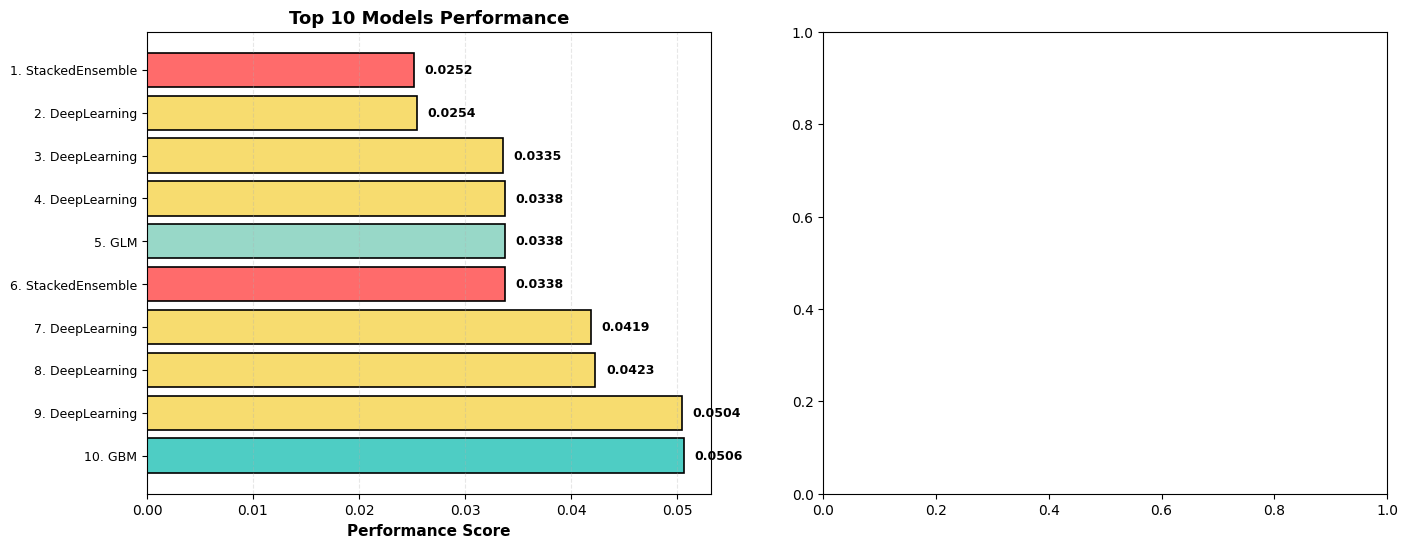

In [15]:
# ==================== 5.1 排行榜深度分析 ====================
#
# 📚 从排行榜中学习什么？
#
# 1. **算法适用性**: 哪种算法在此数据上表现最好？
# 2. **性能差距**: 不同模型间的性能差异有多大？
# 3. **Stacking 优势**: Stacking 是否真的比单模型好？
# 4. **模型选择**: 应该选择哪个模型部署？
#
# 💡 分析策略:
#
# - 提取排行榜中的所有模型
# - 按算法类型分组
# - 可视化性能对比
# - 分析 Top 5 模型的特点

print("=" * 70)
print("📊 排行榜深度分析")
print("=" * 70)

# 获取排行榜
lb = aml.leaderboard
lb_df = lb.as_data_frame()

print(f"\n总模型数: {len(lb_df)}")
print(f"排序指标: {aml.sort_metric}")

# 提取算法类型
lb_df['algo_type'] = lb_df['model_id'].apply(lambda x: x.split('_')[0])

print("\n📈 按算法类型统计:")
print("=" * 70)
algo_counts = lb_df['algo_type'].value_counts()
for algo, count in algo_counts.items():
    print(f"  - {algo}: {count} 个模型")

# 可视化排行榜 Top 10
print("\n📊 Top 10 模型性能对比:")
print("=" * 70)

import matplotlib.pyplot as plt
import numpy as np

top_10 = lb_df.head(10)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 子图1: Top 10 模型的性能条形图
ax1 = axes[0]
colors_map = {'StackedEnsemble': '#FF6B6B', 'GBM': '#4ECDC4', 'XGBoost': '#45B7D1', 
              'DRF': '#FFA07A', 'GLM': '#98D8C8', 'DeepLearning': '#F7DC6F'}
colors = [colors_map.get(algo, '#95a5a6') for algo in top_10['algo_type']]

bars = ax1.barh(range(10), top_10.iloc[:, 1], color=colors, edgecolor='black', linewidth=1.2)
ax1.set_yticks(range(10))
ax1.set_yticklabels([f"{i+1}. {row['algo_type']}" for i, (_, row) in enumerate(top_10.iterrows())], fontsize=9)
ax1.set_xlabel('Performance Score', fontsize=11, fontweight='bold')
ax1.set_title('Top 10 Models Performance', fontsize=13, fontweight='bold')
ax1.grid(axis='x', alpha=0.3, linestyle='--')
ax1.invert_yaxis()

# 添加数值标签
for i, (idx, row) in enumerate(top_10.iterrows()):
    ax1.text(row.iloc[1] + 0.001, i, f'{row.iloc[1]:.4f}', 
             va='center', fontsize=9, fontweight='bold')

# 子图2: 按算法类型的平均性能
ax2 = axes[1]
algo_performance = lb_df.groupby('algo_type').iloc[:, 1].mean().sort_values(ascending=False)
colors2 = [colors_map.get(algo, '#95a5a6') for algo in algo_performance.index]

bars2 = ax2.bar(range(len(algo_performance)), algo_performance.values, color=colors2, 
                edgecolor='black', linewidth=1.2)
ax2.set_xticks(range(len(algo_performance)))
ax2.set_xticklabels(algo_performance.index, rotation=45, ha='right', fontsize=10)
ax2.set_ylabel('Average Performance', fontsize=11, fontweight='bold')
ax2.set_title('Average Performance by Algorithm', fontsize=13, fontweight='bold')
ax2.grid(axis='y', alpha=0.3, linestyle='--')

# 添加数值标签
for i, (algo, perf) in enumerate(algo_performance.items()):
    ax2.text(i, perf + 0.001, f'{perf:.4f}', ha='center', va='bottom', 
             fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

# 分析结论
print("\n💡 排行榜分析结论:")
print("=" * 70)

# 1. 榜首模型
print(f"\n1️⃣  榜首模型:")
print(f"   - 模型ID: {lb_df.iloc[0]['model_id']}")
print(f"   - 算法类型: {lb_df.iloc[0]['algo_type']}")
print(f"   - 性能得分: {lb_df.iloc[0, 1]:.4f}")

if lb_df.iloc[0]['algo_type'] == 'StackedEnsemble':
    print(f"   → Stacking 模型榜首,说明模型融合在此数据上有效")
else:
    print(f"   → 单模型榜首,说明数据相对简单或该算法特别适合")

# 2. 性能差距
if len(lb_df) > 1:
    perf_range = lb_df.iloc[0, 1] - lb_df.iloc[-1, 1]
    print(f"\n2️⃣  性能差距:")
    print(f"   - 最好: {lb_df.iloc[0, 1]:.4f}")
    print(f"   - 最差: {lb_df.iloc[-1, 1]:.4f}")
    print(f"   - 差距: {perf_range:.4f}")
    
    if perf_range > 0.1:
        print(f"   → 模型选择很重要,差距较大")
    else:
        print(f"   → 模型间差距不大,可以选择简单模型")

# 3. 算法表现
best_algo = algo_performance.index[0]
print(f"\n3️⃣  最佳算法家族:")
print(f"   - {best_algo} (平均性能: {algo_performance.iloc[0]:.4f})")
print(f"   → 此数据集更适合 {best_algo} 类型的模型")

print("\n🎯 学习要点:")
print("   1. 观察哪种算法家族表现最好")
print("   2. 分析 Stacking 是否提供明显提升")
print("   3. 评估榜首和榜二的差距,决定是否需要复杂模型")
print("   4. 为后续手动调优选择算法方向")

print("=" * 70)

---

## 📚 从 H2O AutoML 学习: 深度分析篇

> 💡 **这是本节的核心内容！**
>
> AutoML 不仅能帮我们训练模型，更重要的是：
> **从 H2O AutoML 的决策中学习机器学习的最佳实践**
>
> 本章将深入分析 H2O AutoML 的选择，包括:
> - ✅ 排行榜深度分析 (理解模型性能差异)
> - ✅ Stacking 策略学习 (模型融合)
> - ✅ 特征工程洞察 (变量重要性)
> - ✅ 超参数优化 (最佳配置分析)

---

### 5.1 深度解读排行榜 ⭐⭐

**学习目标**:
- 理解为什么某些模型表现更好
- 学习模型适用性判断
- 掌握排行榜的使用技巧

In [ ]:
# 对于支持的模型，可以计算SHAP值
# 注意：不是所有H2O模型都支持SHAP

try:
    # 计算SHAP值
    shap_values = best_model.predict_contributions(test)
    print("SHAP值（前5行）:")
    shap_values.head(5)
except:
    print("该模型不支持SHAP值计算")

---

## 5. 回归任务示例

In [16]:
# 加载回归数据集
boston_url = "https://s3.amazonaws.com/h2o-public-test-data/smalldata/gbm_test/BostonHousing.csv"
boston = h2o.import_file(boston_url)

# 设置目标和特征
target_reg = 'medv'
features_reg = boston.columns
features_reg.remove(target_reg)

# 划分数据
train_reg, test_reg = boston.split_frame(ratios=[0.8], seed=42)

# 训练AutoML
aml_reg = H2OAutoML(
    max_runtime_secs=180,
    seed=42
)

print("开始回归任务训练...")
aml_reg.train(x=features_reg, y=target_reg, training_frame=train_reg)

# 评估
perf_reg = aml_reg.leader.model_performance(test_reg)
print("\n回归模型性能:")
print(perf_reg)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
开始回归任务训练...
AutoML progress: |
12:01:07.753: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%

回归模型性能:
ModelMetricsRegressionGLM: stackedensemble
** Reported on test data. **

MSE: 10.30627412233415
RMSE: 3.2103386304771884
MAE: 1.963883002406571
RMSLE: 0.14458051469514901
Mean Residual Deviance: 10.30627412233415
R^2: 0.8854454982829614
Null degrees of freedom: 109
Residual degrees of freedom: 96
Null deviance: 9939.011161232786
Residual deviance: 1133.6901534567564
AIC: 598.7692905714961


---

## 6. 模型保存与部署

### 6.1 保存模型

In [ ]:
# 保存最佳模型
model_path = h2o.save_model(
    model=best_model,
    path='./h2o_models',
    force=True
)

print(f"✅ 模型已保存到: {model_path}")

### 6.2 加载模型

In [ ]:
# 加载保存的模型
loaded_model = h2o.load_model(model_path)

# 使用加载的模型预测
loaded_predictions = loaded_model.predict(test)

print("✅ 模型加载成功")
print("\n预测结果（前5行）:")
loaded_predictions.head(5)

### 6.3 导出为 MOJO（生产部署）

In [ ]:
# 导出为 MOJO 格式（跨平台部署）
mojo_path = best_model.download_mojo(
    path='./h2o_models',
    get_genmodel_jar=True  # 下载运行MOJO所需的jar文件
)

print(f"✅ MOJO已导出到: {mojo_path}")
print("\n可以在生产环境中使用MOJO进行快速推理")

---

## 7. 高级特性

### 7.1 自定义训练参数

In [ ]:
# 高级配置
aml_advanced = H2OAutoML(
    max_runtime_secs=300,
    max_models=20,
    
    # 停止条件
    stopping_metric='AUTO',
    stopping_tolerance=0.001,
    stopping_rounds=3,
    
    # 交叉验证
    nfolds=5,
    
    # 保持交叉验证的预测
    keep_cross_validation_predictions=True,
    
    # 保持交叉验证的模型
    keep_cross_validation_models=False,
    
    seed=42
)

print("✅ 高级配置创建成功")

### 7.2 限制算法类型

In [ ]:
# 只使用树模型
aml_trees = H2OAutoML(
    max_runtime_secs=180,
    include_algos=['GBM', 'XGBoost', 'DRF'],  # GBM, XGBoost, Random Forest
    seed=42
)

print("配置为只使用树模型")

---

## 9. 总结与最佳实践

### 📚 H2O AutoML 核心知识点回顾

#### 1. 分布式架构

**核心特点**:
- 内存高效: 列式存储 + 压缩
- 并行计算: 多线程并行训练
- 可扩展: 单机 → 集群

**与其他 AutoML 对比**:
- H2O: 分布式,支持 TB 级数据
- PyCaret/FLAML/Auto-sklearn: 单机,受限于内存

**适用场景**:
- ✅ 大数据集 (> 10GB)
- ✅ 需要并行加速
- ✅ 企业级生产环境

---

#### 2. Stacking 集成策略

**两层架构**:
```
第一层: Base Learners (基础学习器)
  ├── GBM (多个配置)
  ├── XGBoost (多个配置)
  ├── Random Forest
  ├── GLM
  └── Deep Learning

第二层: Meta Learner (元学习器)
  └── GLM/GBM (组合所有基础模型的预测)
```

**为什么有效？**
- 减少偏差和方差
- 错误互补
- 模型多样性

**代价**:
- 推理速度慢
- 模型复杂度高
- 可解释性差

**何时使用？**
- 竞赛: ✅ (追求极致性能)
- 生产: ⚠️ (需权衡延迟)
- 可解释性要求高: ❌ (选单模型)

---

#### 3. 排行榜机制

**生成过程**:
1. 并行训练多个模型
2. 5折交叉验证评估
3. 按 sort_metric 排序
4. 实时更新

**如何解读？**
- 榜首类型: Stacking vs 单模型
- 算法排名: GLM/GBM/XGBoost 谁最好?
- 性能差距: 模型间差异大小

**学习价值**:
- 理解数据特点
- 选择算法方向
- 指导手动调优

---

### 🎯 从 H2O AutoML 学习的四大要点

#### 1️⃣ 排行榜分析

**学习内容**:
- 哪种算法家族表现最好？
- Stacking 提升了多少性能？
- 榜首和榜二的差距如何？

**应用价值**:
- 为手动建模选择算法
- 判断是否需要复杂模型
- 理解数据复杂度

---

#### 2️⃣ Stacking 策略

**学习内容**:
- 如何组合多个模型？
- 元学习器如何工作？
- Base learners 如何选择？

**应用价值**:
- 学习模型融合思想
- 手动实现 Stacking
- 提升模型性能

---

#### 3️⃣ 变量重要性

**学习内容**:
- 哪些特征最重要？
- 特征重要性如何计算？
- 如何应用到特征工程？

**应用价值**:
- 特征选择
- 数据收集优先级
- 业务洞察

---

#### 4️⃣ 模型可解释性

**学习内容**:
- 变量重要性
- 部分依赖图 (PDP)
- SHAP 值

**应用价值**:
- 向业务解释模型
- 诊断模型问题
- 建立信任

---

### 💡 H2O AutoML 使用最佳实践

#### 时间预算设置

| 场景 | 推荐时间 | 说明 |
|------|---------|------|
| 快速验证 | 60-180s | 初步探索,建立 baseline |
| 标准训练 | 300-1800s | 正式项目,平衡速度和性能 |
| 深度搜索 | 3600-7200s | 竞赛冲榜,追求极致性能 |

**设置建议**:
```python
# 开发阶段
H2OAutoML(max_runtime_secs=300)

# 生产阶段
H2OAutoML(max_runtime_secs=1800)

# 竞赛阶段
H2OAutoML(max_runtime_secs=7200)
```

---

#### 内存管理建议

| 数据规模 | 推荐内存 | 说明 |
|---------|---------|------|
| < 1GB | 2-4G | 单机模式 |
| 1-10GB | 8-16G | 单机模式 |
| 10-100GB | 32-64G | 单机或小集群 |
| > 100GB | 集群模式 | 多节点分布式 |

**配置示例**:
```python
# 小数据
h2o.init(max_mem_size='4G')

# 中等数据
h2o.init(max_mem_size='16G')

# 大数据
h2o.connect(url='http://cluster:54321')  # 连接集群
```

---

#### 算法选择策略

**限制算法类型** (加速训练):
```python
# 只使用树模型
H2OAutoML(include_algos=['GBM', 'XGBoost', 'DRF'])

# 排除某些算法
H2OAutoML(exclude_algos=['DeepLearning'])
```

**何时限制？**
- 时间紧迫: 只用快速算法 (GLM, GBM)
- 已知数据特点: 线性数据用 GLM,非线性用树模型
- 资源受限: 排除深度学习

---

#### 部署策略

**MOJO 部署流程**:
```python
# 1. 训练模型
aml.train(...)

# 2. 导出 MOJO
mojo_path = aml.leader.download_mojo(
    path='./models',
    get_genmodel_jar=True
)

# 3. 在生产环境加载 MOJO (Java/Python/R/Scala)
# - 高性能 (10-100x 比 H2O 集群快)
# - 低延迟 (< 10ms)
# - 无依赖 (不需要 H2O 集群)
```

**MOJO vs H2O 集群**:
| 特性 | MOJO | H2O 集群 |
|------|------|---------|
| 推理速度 | ⭐⭐⭐⭐⭐ 很快 | ⭐⭐⭐ 中等 |
| 延迟 | < 10ms | 10-100ms |
| 依赖 | 只需 JAR 文件 | 需要 H2O 集群 |
| 跨平台 | ✅ 支持多语言 | ⚠️ 受限 |
| 适用场景 | 生产部署 | 开发测试 |

---

### ⚠️ 常见陷阱与注意事项

#### 1️⃣ 数据准备陷阱

❌ **错误做法**:
```python
# 忘记转换为因子
data = h2o.import_file('data.csv')
aml.train(y='target', ...)  # 错误!
```

✅ **正确做法**:
```python
data = h2o.import_file('data.csv')
data['target'] = data['target'].asfactor()  # 必须!
aml.train(y='target', ...)
```

---

#### 2️⃣ 内存管理陷阱

❌ **错误做法**:
```python
# 分配过多内存
h2o.init(max_mem_size='32G')  # 系统只有 16G
```

✅ **正确做法**:
```python
# 不超过系统内存的 80%
h2o.init(max_mem_size='12G')  # 系统 16G
```

---

#### 3️⃣ 盲目信任 Stacking

❌ **错误做法**:
- 不分析为什么 Stacking 好
- 忽略推理延迟
- 直接部署 Stacking

✅ **正确做法**:
- 对比 Stacking 和最佳单模型的性能差距
- 如果差距 < 1%,考虑用单模型
- 生产环境评估延迟是否可接受

---

#### 4️⃣ 忽略交叉验证性能

❌ **错误做法**:
- 只看排行榜,不看测试集
- 忽略过拟合风险

✅ **正确做法**:
```python
# 对比交叉验证和测试集性能
cv_perf = aml.leader.model_performance(xval=True)
test_perf = aml.leader.model_performance(test)

print(f"CV Performance: {cv_perf.auc()}")
print(f"Test Performance: {test_perf.auc()}")
```

---

### 🏆 H2O vs 其他 AutoML 工具完整对比

| 特性 | H2O AutoML | FLAML | PyCaret | Auto-sklearn |
|------|-----------|-------|---------|--------------|
| **核心算法** | Stacking | CFO (成本优化) | 遍历对比 | 贝叶斯优化 |
| **分布式** | ✅ 支持集群 | ❌ 单机 | ❌ 单机 | ❌ 单机 |
| **大数据** | ✅ TB 级 | ⚠️ GB 级 | ⚠️ GB 级 | ⚠️ GB 级 |
| **模型融合** | ✅ 自动 Stacking | ❌ 无 | ✅ 手动 | ✅ 自动 |
| **排行榜** | ✅ 实时更新 | ❌ 无 | ✅ 有 | ✅ 有 |
| **可解释性** | ✅ 强 (SHAP/PDP) | ⚠️ 基础 | ✅ 丰富 | ⚠️ 基础 |
| **企业级部署** | ✅ MOJO | ⚠️ 基础 | ⚠️ 基础 | ⚠️ 基础 |
| **训练速度** | ⭐⭐⭐⭐ | ⭐⭐⭐⭐⭐ | ⭐⭐⭐⭐ | ⭐⭐⭐ |
| **易用性** | ⭐⭐⭐ | ⭐⭐⭐⭐ | ⭐⭐⭐⭐⭐ | ⭐⭐⭐ |
| **依赖** | Java 8+ | 轻量 | 轻量 | Linux 推荐 |

**H2O 的独特优势**:
1. **唯一支持大数据的 AutoML**
2. **自动化 Stacking 集成**
3. **企业级 MOJO 部署**
4. **强大的可解释性工具**

**何时选择 H2O？**
- ✅ 数据量大 (> 10GB)
- ✅ 需要极致性能 (Stacking)
- ✅ 企业级生产环境
- ✅ 需要强大可解释性
- ❌ 追求最快速度 → 选 FLAML
- ❌ 需要最简单 API → 选 PyCaret

---

### 🎯 学习建议

#### 对于初学者:

1. **先用起来**: 快速上手 H2O AutoML,体验企业级 AutoML
2. **对比学习**: 将 H2O 结果与其他工具对比
3. **深入理解**: 学习 Stacking 原理,理解为什么性能好
4. **实践应用**: 在多个数据集上实验,总结规律

#### 对于进阶用户:

1. **分析排行榜**: 深入研究不同模型的性能差异
2. **提取洞察**: 从变量重要性中提取特征工程思路
3. **手动 Stacking**: 基于 H2O 的经验,手动实现 Stacking
4. **生产部署**: 学习 MOJO 部署,应用到实际项目

---

## 🎯 练习任务

### 任务 1: 基础应用 (必做)

在 sklearn 的 Wine 数据集上完成分类任务:
- 使用 H2O AutoML (time_budget=120)
- 分析排行榜,找出最佳算法家族
- 查看变量重要性
- 计算测试集性能

### 任务 2: 排行榜深度分析

- 提取所有模型的性能
- 按算法类型分组统计
- 可视化 Top 10 模型对比
- 分析 Stacking 的提升幅度

### 任务 3: Stacking 策略学习 (重点)

- 查看 StackedEnsemble 的组成
- 分析使用了哪些 Base learners
- 理解 Meta learner 的类型
- 对比 AllModels vs BestOfFamily

### 任务 4: 与其他 AutoML 对比

在同一数据集上:
- 使用 H2O (time_budget=180)
- 使用 PyCaret (compare_models)
- 使用 FLAML (time_budget=180)
- 对比速度、性能、易用性

### 任务 5: 生产部署实践

- 训练 H2O 模型
- 导出 MOJO 格式
- (可选) 在 Java 环境中加载 MOJO
- 对比 MOJO 和 H2O 集群的推理速度

---

## 📚 参考资源

### 官方资源
- [H2O AutoML 官方文档](https://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html)
- [H2O Flow UI](https://docs.h2o.ai/h2o/latest-stable/h2o-docs/flow.html)
- [MOJO 部署指南](https://docs.h2o.ai/h2o/latest-stable/h2o-docs/productionizing.html)
- [H2O GitHub](https://github.com/h2oai/h2o-3)

### 扩展阅读
- [Stacking 集成学习论文](https://www.sciencedirect.com/science/article/abs/pii/S0893608005800231)
- [SHAP 值论文](https://arxiv.org/abs/1705.07874)
- [H2O 架构白皮书](https://www.h2o.ai/resources/)

---

**下一步学习**:
- 深度学习 AutoML (Auto-Keras)
- 时序数据 AutoML (Prophet, AutoTS)
- 强化学习 AutoML

**建议学习时间**: 本教程 2-3 小时 (理论 + 实践)

---

✅ **恭喜完成 H2O AutoML 教程！你已经掌握了企业级 AutoML 工具！**

In [17]:
# 关闭H2O集群
h2o.cluster().shutdown()

print("✅ H2O集群已关闭")

H2O session _sid_80dc closed.
✅ H2O集群已关闭


---

## 📚 参考资源

- [H2O AutoML 官方文档](https://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html)
- [H2O Flow UI](https://docs.h2o.ai/h2o/latest-stable/h2o-docs/flow.html)
- [MOJO部署指南](https://docs.h2o.ai/h2o/latest-stable/h2o-docs/productionizing.html)

---

**下一节**: `05_automl_comparison.ipynb` - AutoML工具对比实验